A.S. Lundervold, Feb. 2022

# Introduction

This quick tutorial is meant to increase the DAT255 students' familiarity with the basics of PyTorch and the basic building blocks of artificial neural networks. 

It is a supplement to the material from Lesson 4 and Lesson 6 of the [fastai course](https://course.fast.ai), and [Chapter 4](https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb) of the [fastai textbook](https://github.com/fastai/fastbook). 

> Note that there were slides accompanying this notebook. We went through these in class on Wednesday 16.02.22.

## Objectives
1. A better understanding of what neural networks are and how they're trained
2. Increased familiarity with PyTorch: the deep learning library underlying fastai

## Notebooks

**Part 1:** We'll step through the training of a simple neural network in PyTorch. This is meant to provide a solid understanding of the basic steps of constructing and training a neural network.<br> <br>
**Part 2:** As deep neural networks consist of a set of chained operations on _tensors_, we'll take a closer look at these building blocks: _tensors_ and _tensor operations_


# Setup

In [1]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory, as that makes some difference for the code below.
if 'google.colab' in str(get_ipython()):
    print('The notebook is running on Colab. colab=True.')
    colab=True
else:
    print('The notebook is not running on Colab. colab=False.')
    colab=False

The notebook is not running on Colab. colab=False.


In [2]:
if colab:
    !pip3 install -U torch torchvision

In [3]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, pandas as pd
from pathlib import Path

Set up data directories:

In [4]:
NB_DIR = Path.cwd()
# Change this if you want to store the images that are downloaded
# below elsewhere on your computer.
if colab:
    from google.colab import drive
    drive.mount("/content/gdrive")
    DATADIR = Path("/content/gdrive/MyDrive/Colab Notebooks/data")
    DATADIR.mkdir(exist_ok=True)
if not colab:
    DATADIR = Path.home()/'data'
    DATADIR.mkdir(exist_ok=True)

In [5]:
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms

# Load data

We'll use a famous benchmark data set, widely studied by the computer vision community: [Cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html).

It consists of 60.000 32x32 color images from 10 different classes:

<img src="https://github.com/alu042/DAT158ML-2019/raw/65439e386ef8e42e1e7ab5775b5c14b300d0ff60/Part5-neural_networks/assets/cifar10.png">

Our goal is to create an **image classifier**.

## Load data into PyTorch

PyTorch (and other deep learning frameworks) operate on what's called tensors, which are essentially multidimensional arrays that can be placed on GPUs for accellerated computing. We'll take a closer look at tensor and tensor operations in the next notebook.

To process the Cifar-10 images we need to convert them to tensors. We'll do that as we load the images:

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Mean and std set to 0.5 for each channel
])

trainset = torchvision.datasets.CIFAR10(root=DATADIR, train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root=DATADIR, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


### Inspecting the data

Now we have a training data set:

In [7]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /home/alex/data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

and a test set:

In [8]:
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /home/alex/data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

There are 50.000 training images of dimension 32x32, with 3 color channels, and 10.000 test images:

In [9]:
trainset.data.shape, testset.data.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

Each image is labelled with one of 10 classes:

In [10]:
trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [11]:
len(trainset.classes)

10

Here are the first few labels:

In [12]:
trainset.targets[:4]

[6, 9, 9, 4]

...corresponding to the classes

In [13]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

Let's open an image:

In [14]:
example_img = trainset.data[0]

In [15]:
example_img.shape

(32, 32, 3)

Here's a small section of the image

In [16]:
example_img[:2,:2]

array([[[59, 62, 63],
        [43, 46, 45]],

       [[16, 20, 20],
        [ 0,  0,  0]]], dtype=uint8)

We see that they are NumPy arrays. 

Applying the specified transforms we obtain tensors, scaled using `Normalize`:

In [17]:
trainset.transform(example_img[:2,:2])

tensor([[[-0.5373, -0.6627],
         [-0.8745, -1.0000]],

        [[-0.5137, -0.6392],
         [-0.8431, -1.0000]],

        [[-0.5059, -0.6471],
         [-0.8431, -1.0000]]])

We can plot the image using Matplotlib:

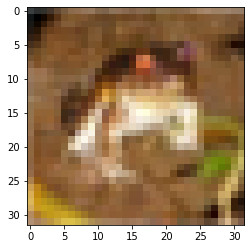

In [18]:
plt.imshow(example_img)
plt.show()

Looks like a frog.. 

In [19]:
trainset.targets[0], trainset.class_to_idx['frog']

(6, 6)

Yup, that's a frog.

Aside: it'll be useful to have an `idx_to_class` dict as well

In [20]:
idx_to_class = {v:k for k, v in trainset.class_to_idx.items()}

In [21]:
idx_to_class

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

## Data loaders

As we've seen, we'd like to feed _batches_ of these tensors onto the GPU when training a neural network. ***Data loaders*** can take care of that for us:

In [22]:
batch_size=16

In [23]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,  shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

It's good practice to check that our data loaders returns what we expect. 

In [24]:
def plot_cifar10():
        images, labels = iter(trainloader).next()
        img = torchvision.utils.make_grid(images)
        
        # Undo the normalization for plotting purposes:
        img = img.numpy()/2 + 0.5 
        
        # We want the images are represented as (height, width, channel):
        img = np.transpose(img, (1, 2, 0)) 
        
        f = plt.figure(figsize=(18,8))
        plt.axis("Off")
        plt.imshow(img)
        plt.show()
        print(f'{[trainloader.dataset.classes[labels[j]] for j in range(batch_size)]}')

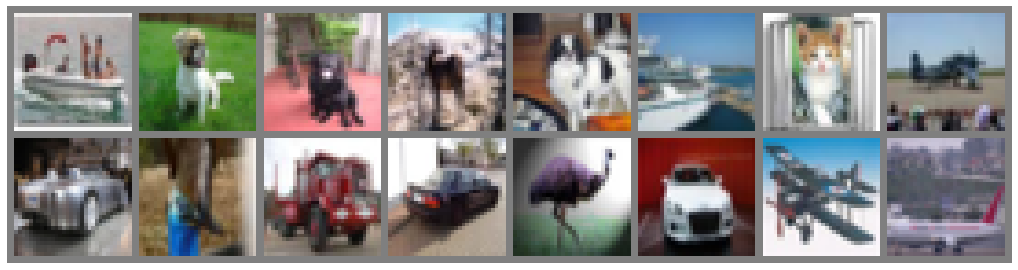

['ship', 'dog', 'dog', 'deer', 'dog', 'ship', 'cat', 'airplane', 'automobile', 'bird', 'truck', 'automobile', 'bird', 'automobile', 'airplane', 'airplane']


In [25]:
plot_cifar10()

# A simple neural network in PyTorch

As we discussed in the lecture, there are two main stages when training a neural network: a forward pass to get values for all the nodes between the input and output, and a backward pass where backpropagation (based on *automatic differentiation* and *dynamic programming*) and gradient descent is used to tweak all the parameters in the network.

To make gradient descent work, we need to be able to take the derivative of each component in the network (these derivatives are computed during backpropagation). Even if it's basically an application of the simple chain rule from calculus, it is a bit complicated to do efficiently. For details about these procedures, see http://cs231n.github.io/optimization-2.

Luckily PyTorch can take care of the differentiation for us (that is, the backward pass) if we create a network inheriting from `nn.Module`:


## A fully-connected neural net in PyTorch



Here's a simple one hidden layer neural network in PyTorch:


In [26]:
input_size = 32*32*3 # The Cifar-10 images are 32x32 with three color channels
hidden_size = 16 # We can choose this number
num_classes = len(trainset.classes)

In [27]:
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        
        super(Net, self).__init__()
        
        # A hidden layer
        self.fc1 = torch.nn.Linear(input_size, hidden_size)  # A tensor of size  (hidden_size) x (input_size)
        
        # An output layer
        self.fc2 = torch.nn.Linear(hidden_size, num_classes) # A tensor of size (num_classes) x (hidden_size)
        
        
    # We need to define what we want to happen in the forward phase (the backward phase is automatic)
    
    def forward(self, x):
        
        # Make the 32x32x3 image into a 32*32*3 = 3072 vector
        x = x.view(x.size(0), -1) 
        
        # Feed the input vector through the hidden layer and an activation function
        x = torch.tanh(self.fc1(x)) 
        
        # Output num_classes of numbers.
        # We'll train the network to output a high number for the correct class
        x = self.fc2(x) 
        
        return x

In [28]:
net = Net(input_size = input_size, hidden_size = hidden_size, num_classes = num_classes)

In [29]:
net

Net(
  (fc1): Linear(in_features=3072, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=10, bias=True)
)

# Training the network

Remember from the fastai course that there are seven steps to train a neural network (this is a slight reformulation of https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb)

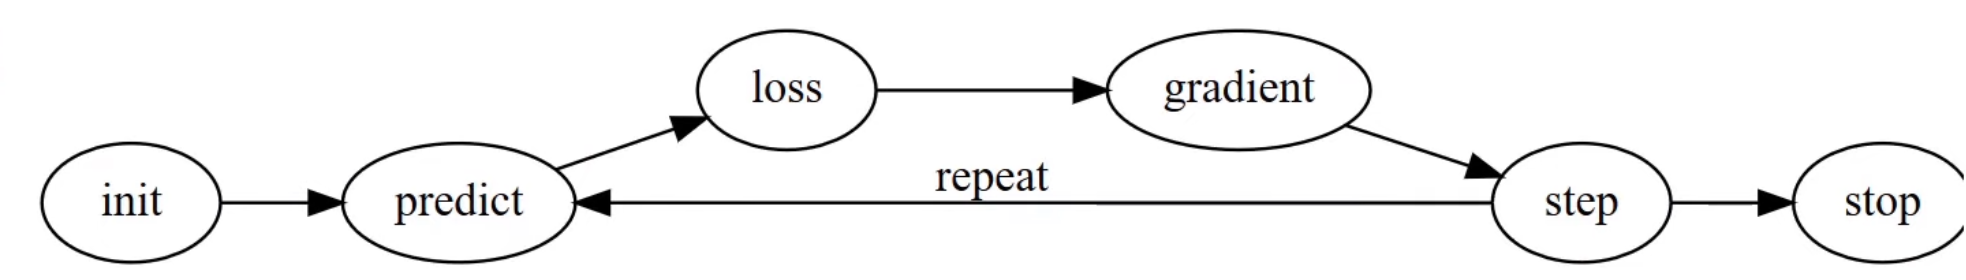<br>
<center><small>Figure from the <a href="https://github.com/fastai/fastbook">fastai book.</a></small></center>

1. _Initialize_ the parameters.
2. Grab a batch of inputs and use the model with its current parameters to make _predictions_.
3. Based on these predictions, calculate how good the model is (its _loss_).
4. Calculate the _gradients_ for each parameter using backpropagation. This measures how changing each parameter would change the loss
5. _Step_ (that is, change) all the parameters based on that calculation.
6. Go back to the step 2, and _repeat_ the process.
7. Iterate until you decide to _stop_ the training process (for instance, because the model is good enough or you don't want to wait any longer).

## 1: Initialization

PyTorch has taken care of the initalization for us by choosing random numbers for the weights and biases:

In [30]:
list(net.parameters())

[Parameter containing:
 tensor([[-0.0112, -0.0126, -0.0007,  ...,  0.0095,  0.0003,  0.0008],
         [ 0.0080, -0.0008,  0.0146,  ...,  0.0144,  0.0020,  0.0143],
         [-0.0031,  0.0084, -0.0043,  ..., -0.0141,  0.0096,  0.0021],
         ...,
         [-0.0012,  0.0160, -0.0123,  ...,  0.0157,  0.0044, -0.0115],
         [-0.0146, -0.0132, -0.0149,  ...,  0.0006,  0.0090,  0.0004],
         [ 0.0033,  0.0159,  0.0083,  ...,  0.0065, -0.0024,  0.0130]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0033,  0.0110, -0.0098,  0.0019, -0.0177,  0.0041,  0.0071, -0.0173,
          0.0093, -0.0040,  0.0142, -0.0044,  0.0017, -0.0001,  0.0160, -0.0044],
        requires_grad=True),
 Parameter containing:
 tensor([[-0.1418, -0.0379,  0.0992, -0.1417, -0.1805,  0.2043,  0.1691, -0.1275,
           0.0172, -0.1947,  0.0557,  0.0611, -0.1951, -0.1356,  0.2295,  0.0542],
         [ 0.0023, -0.1808,  0.1974,  0.0859,  0.0931,  0.0893,  0.0899,  0.1997,
           0.2045,  0.

## 2: Grab a batch and predict

In [31]:
# Get the next batch
i, data = next(enumerate(trainloader, 0))

Let's do a quick sanity check first:

We expect to have collected the first batch of 16 images and their labels:

In [32]:
images, labels = data

In [33]:
len(images), len(labels)

(16, 16)

Their labels are

In [34]:
labels

tensor([0, 7, 6, 8, 7, 0, 8, 0, 0, 4, 1, 9, 8, 9, 9, 6])

...which means 

In [35]:
y_true = [idx_to_class[int(l)] for l in labels]
y_true

['airplane',
 'horse',
 'frog',
 'ship',
 'horse',
 'airplane',
 'ship',
 'airplane',
 'airplane',
 'deer',
 'automobile',
 'truck',
 'ship',
 'truck',
 'truck',
 'frog']

The images are of course torch tensors:

In [36]:
images.shape

torch.Size([16, 3, 32, 32])

16 images, 3 color channels, dimensions 32x32

### Feeding the batch to the network

In [37]:
net

Net(
  (fc1): Linear(in_features=3072, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=10, bias=True)
)

Computing the predictions from the network for these images is simple, as the network can be treated as a function

In [38]:
predictions = net(images)

In [39]:
predictions.shape

torch.Size([16, 10])

We obtained 16 predictions of 10 different classes.

Here's the first one:

In [40]:
predictions[0]

tensor([ 0.2767, -0.1070, -0.1674,  0.3979,  0.0650,  0.1288, -0.3011, -0.1282,
        -0.3553, -0.1121], grad_fn=<SelectBackward0>)

> Our goal is to make the element in each vector that corresponds to the correct label for the corresponding image as large as possible, while the rest are small.

Since we haven't trained our network at all yet, we can't expect it to produce any good predictions:

In [41]:
_, predicted_classes = torch.max(predictions.data, 1)
predicted_classes

tensor([3, 0, 4, 3, 0, 0, 0, 1, 0, 3, 1, 0, 0, 1, 0, 3])

We can compare this to the correct outputs:

In [42]:
y_pred = [idx_to_class[int(p)] for p in predicted_classes]

In [43]:
list(zip(y_true, y_pred))

[('airplane', 'cat'),
 ('horse', 'airplane'),
 ('frog', 'deer'),
 ('ship', 'cat'),
 ('horse', 'airplane'),
 ('airplane', 'airplane'),
 ('ship', 'airplane'),
 ('airplane', 'automobile'),
 ('airplane', 'airplane'),
 ('deer', 'cat'),
 ('automobile', 'automobile'),
 ('truck', 'airplane'),
 ('ship', 'airplane'),
 ('truck', 'automobile'),
 ('truck', 'airplane'),
 ('frog', 'cat')]

Chances are that very few of the predictions will be correct. This is because we've initialized the network with random weights, and it hasn't been trained yet.

## 3: Calculate loss

To measure the discrepancy between the predictions and the true labels we need a loss function suited for classification tasks. As explained in fastai [Chapter 5](https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb), the **cross-entropy loss** fits the bill.

In [44]:
loss_func = torch.nn.CrossEntropyLoss()

Let's calculate the loss for our current batch:

In [45]:
current_loss = loss_func(predictions, labels)

In [46]:
current_loss

tensor(2.3383, grad_fn=<NllLossBackward0>)

## 4: Calculate gradients

Using the `backward` method PyTorch can calculate how much each weight in the network contributed to the loss by calculating the gradient of the loss with respect to each of them (using a technique called automatic differentation, which is related to the chain rule you know from calculus):

In [47]:
current_loss.backward()

## 5: Step / update the weights

Now we can update all the weights using gradient descent. For that we need to set a learning rate:

In [48]:
lr = 0.01

In [49]:
import torch.functional as F

We'll use a built-in stochastic gradient descent optimizer from PyTorch:

In [50]:
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

> Aside: Check source code



Take one step with the optimizer to modify each weight:


In [51]:
optimizer.step()

The network has now been trained _a tiny bit_ (it has learned from the first 16 images).

### Did that help?

Let's check

In [52]:
predictions = net(images)

In [53]:
_, predicted_classes = torch.max(predictions.data, 1)

In [54]:
y_pred = [idx_to_class[int(p)] for p in predicted_classes]

In [55]:
list(zip(y_true, y_pred))

[('airplane', 'airplane'),
 ('horse', 'airplane'),
 ('frog', 'deer'),
 ('ship', 'cat'),
 ('horse', 'airplane'),
 ('airplane', 'airplane'),
 ('ship', 'cat'),
 ('airplane', 'airplane'),
 ('airplane', 'airplane'),
 ('deer', 'cat'),
 ('automobile', 'automobile'),
 ('truck', 'airplane'),
 ('ship', 'airplane'),
 ('truck', 'automobile'),
 ('truck', 'automobile'),
 ('frog', 'frog')]

The model imporved, but not by much. Can also see that the loss didn't decrease significantly.

In [56]:
loss_func(predictions, labels)

tensor(2.1469, grad_fn=<NllLossBackward0>)

## 6: Go back to step 2 and repeat

The idea now is to repeat this batch by batch, until we've been through the entire training data set multiple times. The idea is that gradient descent will then be able to find good settings for all the weights, and we can use those when new data is fed through the network.

Let's first create a simple function for checking the accuracy of the network on the test data:

In [57]:
def check_accuracy(net, dataloader=testloader):
        correct = 0
        total = 0
        
        # Feed all the test data through the net and count the number of correct predictions:
        for data in testloader:
            images, labels = data
            predictions = net(images)
            _, predicted_classes = torch.max(predictions.data, 1)
            total += labels.size(0)
            correct += (predicted_classes == labels).sum()
        
        accuracy = correct / total
            
        print('The accuracy of the network on the 10.000 test images is: %d %%' % (100 * accuracy))
        
        return accuracy

Our current accuracy after training on a single batch is

In [58]:
_ = check_accuracy(net)

The accuracy of the network on the 10.000 test images is: 13 %


Since the network is essentially untrained this is as expected (randomly guessing among the 10 classes gives an accuracy of 10%).

The cell below the optimizer initalization contains the entire above procedure. You can CTRL+ENTER this cell to run it multiple times. You're training a neural network!

In [59]:
net = Net(input_size = input_size, hidden_size = hidden_size, num_classes = num_classes)

lr = 0.001
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [60]:
###################################################
# 2. Grab the next batch and compute predictions
###################################################

i, data = next(enumerate(trainloader, 0))
images, labels = data
# A technicality: we have to zero out the gradients each time, 
# otherwise they'll accumulate
optimizer.zero_grad()
predictions = net(images)


###################################################
# 3. Compute the loss
###################################################

loss = loss_func(predictions, labels)
print(f'Current loss: {loss}')


###################################################
# 4. Calculate the gradients
###################################################

loss.backward()


###################################################
# 5. Step
###################################################

optimizer.step()


###################################################
###################################################

# Compute the current accuracy
_ = check_accuracy(net)

Current loss: 2.320000648498535
The accuracy of the network on the 10.000 test images is: 9 %


> **Question:** How many times do you have to run the above cell to go through the entire training data set once?



Let's make a loop!


## 7: Iterate until stopping criterion is met

Stopping criterion: We'll go through the entire training set 3 times. Feel free to decrease or increase this (training will take quite some time if running on a CPU, not a GPU).

In [61]:
num_epochs = 2

In [62]:
%%time
# We record the accuracies during training for later analysis
accuracies = [check_accuracy(net), ]

for epoch in range(num_epochs): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        # forward + backward + optimize
        predictions = net(inputs)
        loss = loss_func(predictions, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.data
        if i % 1000 == 999:    # print every 1000nd batch         
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            
            acc = check_accuracy(net)
            
            print("-"*40)
            accuracies.append(acc)
            running_loss = 0.0

print('Training complete')

The accuracy of the network on the 10.000 test images is: 9 %
[1,  1000] loss: 2.153
The accuracy of the network on the 10.000 test images is: 26 %
----------------------------------------
[1,  2000] loss: 2.051
The accuracy of the network on the 10.000 test images is: 30 %
----------------------------------------
[1,  3000] loss: 1.989
The accuracy of the network on the 10.000 test images is: 32 %
----------------------------------------
[2,  1000] loss: 1.943
The accuracy of the network on the 10.000 test images is: 34 %
----------------------------------------
[2,  2000] loss: 1.919
The accuracy of the network on the 10.000 test images is: 35 %
----------------------------------------
[2,  3000] loss: 1.896
The accuracy of the network on the 10.000 test images is: 35 %
----------------------------------------
Training complete
CPU times: user 3min 31s, sys: 5.1 s, total: 3min 36s
Wall time: 14 s


Here's a plot of the accuracies obtained during training:

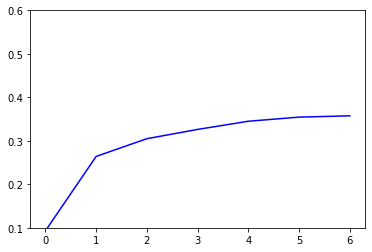

In [63]:
plt.ylim([0.1, 0.6])
plt.plot(accuracies, 'b')
plt.show()

We see that we quickly reach what seems to be a plateau in accuracy. We need something else to go beyond this...

## Evaluate the results

As you know from basic machine learning, one should always turn to the **confusion matrix** when evaluating a classifier:

First we collect lists of the predicted labels for the test data and the true labels:

In [64]:
y_pred = []
y_true = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        predictions = net(images)
        _, predicted_classes = torch.max(predictions.data, 1)
        y_pred.append(list(predicted_classes.numpy()))
        y_true.append(list(labels.numpy()))    

In [65]:
# Flatten the lists (they are lists of sublists of length batch size)
y_pred = [i for sublist in y_pred for i in sublist]
y_true = [i for sublist in y_true for i in sublist]

...then compute the confusion matrix:

In [68]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

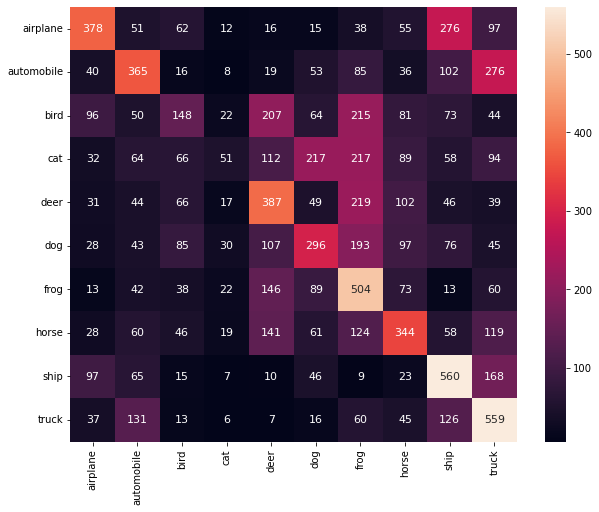

In [69]:
import seaborn as sns

df_cm = pd.DataFrame(cm, testset.classes, testset.classes)
plt.figure(figsize=(10,8))
sns.heatmap(df_cm, annot=True, fmt=f'.0f', annot_kws={"size": 11}) 
plt.show()

> **That's it, basically!** Now you know the basics of training neural networks!

# Wrapping up

**That's it, basically**! Now you know the basics of training neural networks from skratch

However, our above neural network is not particularly powerful. One can of course do much, much better...

> **Your turn!** Try adding a second hidden layer to the network. How does it influence performance? Try experimenting with the sizes of the hidden layers. Are you able to obtain a better result than above? Note: if you remove the "check_accuracy" call in the training loop it'll speed up the training.

> **Your turn!** Try to use fastai's `cnn_learner` with the CIFAR10 data set, and you'll see what I mean when I say that one can do much, much better...


# The "deep" in deep learning

Fundamentally, *deep learning* for neural networks simply means adding more than one hidden layer: i.e. making the network *deep*. If you modify the above neural network definition by adding a second hidden layer, then you're actually doing deep learning.

However, "deep learning" also refers to an entire field of research, chock-full of exciting ideas, models and techniques. As you've seen in the lectures, it's an extremely hot field that exploded a few years ago and is still growing.

In the above example we constructed a simple *fully-connected* neural network, and applied it to an image classification task. That is not a reasonable approach if you care about performance. The most poweful types of neural networks for image analysis are the so-called **convolutional neural networks**.

Let's build one.

# Convolutional neural networks

In [70]:
%%HTML
<video width=60% autoplay loop> <source src="assets/CNN-viz-otavio-good.mp4"> </video>

## A CNN in PyTorch

In [71]:
# Selecting some parameters for the model
kernel_size = 5
out_channels = [10, 20]
fc_features = [320, 50]

In [72]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Convolution and pooling:
        self.conv1 = torch.nn.Conv2d(in_channels=3, 
                                     out_channels=out_channels[0], 
                                     kernel_size=kernel_size)
        
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(in_channels=out_channels[0], 
                                     out_channels=out_channels[1], 
                                     kernel_size=kernel_size)
        
        
        # Some fully-connected layers at the end:
        self.fc1 = torch.nn.Linear(in_features=500, 
                                   out_features=fc_features[0])
        
        self.fc2 = torch.nn.Linear(in_features=fc_features[0], 
                                   out_features=fc_features[1])
        
        # Output layer:
        self.fc3 = torch.nn.Linear(in_features=fc_features[1], 
                                   out_features=num_classes)
        
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [73]:
cnn = CNN()

In [74]:
cnn

CNN(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=320, bias=True)
  (fc2): Linear(in_features=320, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)

In [75]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

In [76]:
num_epochs = 2

In [77]:
%%time 
for epoch in range(num_epochs): 

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.data
        if i % 1000 == 999:    # print every 1000nd batch         
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Training complete')

[1,  1000] loss: 2.282
[1,  2000] loss: 2.001
[1,  3000] loss: 1.745
[2,  1000] loss: 1.596
[2,  2000] loss: 1.503
[2,  3000] loss: 1.439
Training complete
CPU times: user 3min 32s, sys: 5.04 s, total: 3min 37s
Wall time: 13.6 s


In [78]:
_ = check_accuracy(cnn)

The accuracy of the network on the 10.000 test images is: 50 %


Confusion matrix:

In [79]:
y_pred = []
y_true = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        predictions = cnn(images)
        _, predicted_classes = torch.max(predictions.data, 1)
        y_pred.append(list(predicted_classes.numpy()))
        y_true.append(list(labels.numpy()))        

y_pred = [i for sublist in y_pred for i in sublist]
y_true = [i for sublist in y_true for i in sublist]

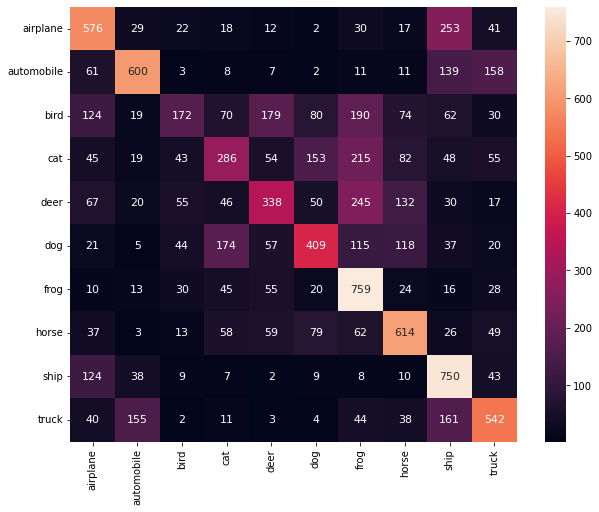

In [80]:
cm = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cm, testset.classes, testset.classes)
plt.figure(figsize=(10,8))
sns.heatmap(df_cm, annot=True, fmt=f'.0f', annot_kws={"size": 11}) 
plt.show()

> **Your turn!** Try playing with the parameters we chose for our CNN. The kernel_size, the number of output channels (which is the width of the network) etc. You can also try adding another convolutional layer to the network to check whether that improves the result. Note that the training time will increase as you increase the amount of parameters.

In [82]:
# Number of trainable parameters for the current CNN model:
sum(p.numel() for p in cnn.parameters() if p.requires_grad)

182660